## Implement Oriented Bounding Box (OBB) Detection Using YOLO from scratch

In this assignment, you will create a dataset class for a subset of the Dota OBB dataset and implement Oriented YOLO from scratch.

##Dataset:
You will use a subset of Dota Dataset, consisting of 58 images. Dataset can be downloaded from:

https://universe.roboflow.com/rotated-object-detection/dota-demo/dataset/1

##Tasks:

1. Create a dataset class for the above dataset
2. Implement/Use a Backbone Network (you are allowed to use a pretrained CNN i.e., Darknet, ResNet, VGG)
3. Implement Oriented YOLO Head
5. Implement the training loop for Oriented YOLO
6. Evaluate the model on the test set


#import

In [2]:
from IPython.display import clear_output

In [3]:
from torch.utils.data import Dataset, DataLoader # Added missing import statement
from torchvision.transforms import transforms, InterpolationMode
import os
import yaml
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.transforms import InterpolationMode
import torch

In [4]:
import torch.multiprocessing as mp

mp.set_start_method('fork', force=True)

In [5]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="VwbuDTnQx4AhvBx6UbFg")
project = rf.workspace("rotated-object-detection").project("dota-demo")
version = project.version(1)
dataset = version.download("yolov5-obb")


loading Roboflow workspace...
loading Roboflow project...


# 1.dataset class

1 - Get the image and label files

2 - Load class names and image and label


In [12]:
class YOLODataset(Dataset):
    def __init__(self, yaml_file, img_size=640, augment=False, split='train'):
        with open(yaml_file, 'r') as f:
            self.yaml = yaml.safe_load(f)

        self.root_dir = self.yaml['path']
        self.split = split
        self.img_size = img_size
        self.augment = augment # data augmentation

        # Load the Roboflow dataset
        rf = Roboflow(api_key="VwbuDTnQx4AhvBx6UbFg")
        project = rf.workspace('rotated-object-detection').project("dota-demo")
        self.dataset = project.version(1).download("yolov5-obb")
        self.root_dir = self.dataset.location

        # Get the image files for the specified split
        if split == 'train':
            self.img_files = [f for f in os.listdir(self.dataset.location + "/train/images") if f.endswith(('.jpg', '.png'))]
        elif split == 'val':
            self.img_files = [f for f in os.listdir(self.dataset.location + "/valid/images") if f.endswith(('.jpg', '.png'))]
        elif split == 'test':
            self.img_files = [f for f in os.listdir(self.dataset.location + "/test/images") if f.endswith(('.jpg', '.png'))]
        else:
            raise ValueError(f"Invalid split: {split}")

        # Get the label files for the specified split
        self.label_files = [os.path.join(self.root_dir, path.replace('images', 'labelTxt').replace('.jpg', '.txt').replace('.png', '.txt')) for path in self.img_files]

        self.transform = transforms.Compose([
            transforms.Resize((img_size, img_size), interpolation=InterpolationMode.BILINEAR),
            transforms.ToTensor(),
        ])

        # Load class names
        self.class_names = self.yaml['names']
        self.class_to_id = {name: i for i, name in enumerate(self.class_names)}

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, f"{self.split}/images", self.img_files[idx])
        label_path = self.label_files[idx]

        # Load image
        #print(f"Image path: {img_path}")  # Print the image path for debugging
        img = Image.open(img_path).convert('RGB')

        # Preserve aspect ratio during resizing
        w, h = img.size
        scale_factor = min(self.img_size / w, self.img_size / h)
        new_size = (int(w * scale_factor), int(h * scale_factor))
        img = transforms.Resize(new_size, interpolation=InterpolationMode.BILINEAR)(img)

        # Pad image to square
        pad_w = self.img_size - new_size[0]
        pad_h = self.img_size - new_size[1]
        img = transforms.Pad((pad_w // 2, pad_h // 2, pad_w - pad_w // 2, pad_h - pad_h // 2))(img)

        img = self.transform(img)

        # Load labels
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                labels = []
                for line in f.readlines():
                    parts = line.strip().split()
                    if len(parts) == 10:  # 8 coordinates + class name + score
                        x1, y1, x2, y2, x3, y3, x4, y4, class_name, score = parts
                        x1, y1, x2, y2, x3, y3, x4, y4 = map(float, [x1, y1, x2, y2, x3, y3, x4, y4])

                        # Calculate center x, center y, width, and height
                        center_x = (x1 + x2 + x3 + x4) / 4 / self.img_size
                        center_y = (y1 + y2 + y3 + y4) / 4 / self.img_size
                        width = max(x1, x2, x3, x4) - min(x1, x2, x3, x4)
                        height = max(y1, y2, y3, y4) - min(y1, y2, y3, y4)
                        width /= self.img_size
                        height /= self.img_size

                        class_id = self.class_to_id[class_name]
                        labels.append([class_id, center_x, center_y, width, height])
                    else:
                        print(f"Skipping invalid label in {label_path}")
            labels = torch.tensor(labels)
        else:
            labels = torch.zeros((0, 5))

        return img, labels

## Create dataloaders


In [13]:
def create_dataloaders(dataset_location, batch_size=16, img_size=640, num_workers=2):
    train_dataset = YOLODataset(yaml_file=dataset_location, img_size=img_size, augment=True, split='train')
    val_dataset = YOLODataset(yaml_file=dataset_location, img_size=img_size, augment=False, split='val')
    test_dataset = YOLODataset(yaml_file=dataset_location, img_size=img_size, augment=False, split='test')

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

    return train_loader, val_loader, test_loader

In [27]:
train_dataset = YOLODataset(yaml_file='/content/DOTA-Demo-1/data.yaml', img_size=640, augment=True, split='train')
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True,num_workers=2, pin_memory=True)

# Get an image and labels from the training dataset
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Plot the image with labels


loading Roboflow workspace...
loading Roboflow project...


##Plot

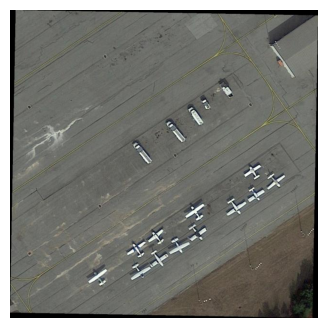

In [42]:

import matplotlib.pyplot as plt

def plot_image_with_labels(image, labels, class_names):
  """Plots an image with labels."""
  plt.figure(figsize=(4, 4))
  plt.imshow(image.permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C)

  for label in labels:
    class_id, center_x, center_y, width, height = label
    class_name = class_names[int(class_id)]

    # Calculate bounding box coordinates
    x1 = (center_x - width / 2) * image.shape[2]
    y1 = (center_y - height / 2) * image.shape[1]
    x2 = (center_x + width / 2) * image.shape[2]
    y2 = (center_y + height / 2) * image.shape[1]

    plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                    linewidth=2, edgecolor='r', facecolor='none'))
    plt.text(x1, y1, class_name, color='r', fontsize=12)

  plt.axis('off')
  plt.show()

# Get an image and labels from the training dataset
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Plot the image with labels
plot_image_with_labels(images[0], labels[0], train_dataset.class_names)

In [29]:
print(train_dataset.class_to_id)
print(train_dataset.class_names)
print(len(train_dataset))

{'harbor': 0, 'large-vehicle': 1, 'plane': 2, 'ship': 3, 'small-vehicle': 4}
['harbor', 'large-vehicle', 'plane', 'ship', 'small-vehicle']
40


#2.Backbone Network

> After loading the pre-trained backbone model, the code modifies it to fit the YOLO architecture. Specifically, it replaces the avgpool layer with an AdaptiveAvgPool2d layer, and the fc (fully connected) layer with a new linear layer that outputs 512 features.



In [30]:
import torch.nn as nn
import torchvision.models as models
from torchvision.models import resnet18

class YOLOBackbone(nn.Module):
    def __init__(self, backbone_name='resnet18', pretrained=True):
        super(YOLOBackbone, self).__init__()

        # Load the pre-trained backbone model
        if backbone_name == 'resnet18':
            self.backbone = models.resnet18(pretrained=pretrained)
        else:
            raise ValueError(f"Unsupported backbone model: {backbone_name}")

        # Modify the backbone to fit the YOLO architecture
        self.backbone.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, 512)

    def forward(self, x):
        # Pass the input through the backbone
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)

        x = self.backbone.avgpool(x)
        x = self.backbone.fc(x.flatten(1))

        return x

# 3.Oriented YOLO Head
> This head is specifically tailored for oriented bounding box prediction, where the model outputs not only the position and size of the bounding boxes but also their orientation.







In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class OrientedYOLOHead(nn.Module):
    def __init__(self, num_classes, num_anchors, input_size):
        super(OrientedYOLOHead, self).__init__()
        self.num_classes = num_classes
        self.num_anchors = num_anchors
        self.input_size = input_size

        self.conv1 = nn.Conv2d(in_channels=input_size[0], out_channels=512, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(512)
        self.conv2 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(1024)
        self.conv3 = nn.Conv2d(in_channels=1024, out_channels=self.num_anchors * (5 + self.num_classes), kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        # Reshape the input tensor to have spatial dimensions
        x = x.view(-1, self.input_size[0], self.input_size[1], self.input_size[2])
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.conv3(x)
        return x.reshape(-1, self.num_anchors, 5 + self.num_classes, self.input_size[1], self.input_size[2])



- This loss function is designed to be used with a YOLO-based object detection model that predicts not only the bounding box coordinates but also the orientation of the objects.

In [32]:
def yolo_loss(pred, target, num_classes, num_anchors):
    # Unpack the prediction and target tensors
    batch_size, _, _, height, width = pred.shape
    conf_pred, cls_pred, bbox_pred, angle_pred = torch.split(pred, [1, num_classes, 4, 1], dim=2)
    conf_target, cls_target, bbox_target, angle_target = torch.split(target, [1, num_classes, 4, 1], dim=2)

    # Classification loss
    cls_loss = F.binary_cross_entropy_with_logits(cls_pred, cls_target)

    # Localization loss
    bbox_loss = F.smooth_l1_loss(bbox_pred, bbox_target)
    angle_loss = F.smooth_l1_loss(angle_pred, angle_target)
    loc_loss = bbox_loss + angle_loss

    # Confidence loss
    conf_loss = F.binary_cross_entropy_with_logits(conf_pred, conf_target)

    # Total loss
    total_loss = cls_loss + loc_loss + conf_loss

    return total_loss

#4.training loop for Oriented YOLO

In [33]:
import torch.optim as optim
# Define the necessary variables
num_classes = 10  # Example: Set the number of classes in your dataset
num_anchors = 5    # Example: Set the number of anchors per grid cell
#input_size = [1024, 16, 16]  # Example: Set the input size for the YOLO head
num_epochs = 10
dataset_location = "/content/DOTA-Demo-1/data.yaml"
train_loader, _, _ = create_dataloaders(dataset_location=dataset_location) # Call the function to create dataloaders and unpack the return values


loading Roboflow workspace...
loading Roboflow project...
loading Roboflow workspace...
loading Roboflow project...
loading Roboflow workspace...
loading Roboflow project...


In [34]:
backbone = YOLOBackbone()

# The input size for the YOLO head is determined by the output features of the backbone network
input_size = [backbone.backbone.fc.out_features, 16, 16]

model = OrientedYOLOHead(num_classes, num_anchors, input_size)
optimizer = optim.Adam(model.parameters(), lr=0.001)

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.


In [ ]:
# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (images, targets) in enumerate(train_loader):
        # Forward
        # Pass the images through the backbone
        features = backbone(images)

        # Check the shape of features and print it for debugging
        print("Shape of features:", features.shape)

        # Reshape the features to match the expected input of the YOLO head
        features = features.view(-1, input_size[0], input_size[1], input_size[2]) # Reshape features to match YOLO head input

        # Check if the reshaping was successful by printing the new shape
        print("Shape of features after reshaping:", features.shape)

        outputs = model(features)

        # Compute loss
        loss = yolo_loss(outputs, targets, num_classes, num_anchors)

        # Backpropagation and optimizer step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update running loss
        running_loss += loss.item()

        # Log training progress
        if (i+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {running_loss/10:.4f}')
            running_loss = 0.0

    # Save checkpoint
    if (epoch+1) % 10 == 0:
        torch.save(model.state_dict(), f'checkpoint_epoch_{epoch+1}.pth')